# SocialAL Model
# Data simulation and parameter recovery - multiple subjects
KLS 8.30.19  
Project info: https://osf.io/b48n2/

Model modified from :
Fareri, D. S., Chang, L. J., & Delgado, M. R. (2012). Effects of direct social experience on trust decisions and neural reward circuitry. Frontiers in Neuroscience, 6, 1–17. https://doi.org/10.3389/fnins.2012.00148

### Python version

In [1]:
import sys
print(sys.version)  

3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Load modules

In [2]:
import numpy as np
import random
import math
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Define functions (from model development notebook)

In [3]:
def update_value(Prob, EV, choice, response):
    invest = [0,3,6,9]
    retain = [9-x for x in invest] #print ("Retain list is: ", retain)
    shared = [2*x for x in invest] #print ("Shared list is: ", shared)
    EV[choice-1] = retain[choice-1] + Prob*shared[choice-1]
    return EV

def update_prob(recip, Prob, a_gain, a_loss):
    gain = max(recip - Prob, 0)
    loss = min(recip - Prob, 0)
    Prob = Prob + a_gain * gain + a_loss * loss
    return Prob

def get_action_selection_prob(beta, EV, choice):
    numerator = np.exp(beta*EV[choice-1])
    denominator = np.sum([np.exp(beta*x) for x in EV])
    actionProb = numerator/denominator
    return actionProb

def get_action_selection_probs(beta, EV):
    actionProbs = [get_action_selection_prob(beta, EV, x) for x in range(1,5)]
    return actionProbs

def action_selection(actionProb):
    cumprob = np.cumsum(actionProb) # cumulative probability 
    num = random.uniform(0,1) # pick a random number between 0 and 1, see where it falls
    if num < cumprob[0]: action = 1
    elif num < cumprob[1]: action = 2
    elif num < cumprob[2]: action = 3
    else: action = 4   
    return action

In [4]:
def select_response(prob):     
    n = random.uniform(0,1)
    if n > prob:
        response = 0
    else:
        response = 1
    return response

### Set constants

In [5]:
recip_rates = {0: 0.93, 1:0.6, 2:0.07}

### New function to simulate data for one sub

In [6]:
def sim_data(tn, params):
    a_gain = params[0]
    a_loss = params[1]
    beta = params[2]
    
    # initialize variables
    Probs = [0.5, 0.5, 0.5]
    EVs = [[9,9,9,9],[9,9,9,9],[9,9,9,9]]
    
    # generate trial sequence
    trial_sequence = np.repeat([0,1,2], tn)
    random.shuffle(trial_sequence) #print(trial_sequence)
    
    choices = []
    responses = []
    
    for x in range(0,len(trial_sequence)):
        t = trial_sequence[x] 
        
        # Make a choice
        choice = action_selection(get_action_selection_probs(beta, EVs[t]))
        choices.append(choice) 
    
        # Get a response
        recip_rate = recip_rates.get(t) 
        
        response = select_response(recip_rate) 
        responses.append(response)
    
        # after choice, update probability
        Probs[t] = update_prob(response, Probs[t], a_gain, a_loss) 
    
        # then update value
        EVs[t] = update_value(Probs[t], EVs[t], choice, response) 
        
    data = {'Stim_Sequence': trial_sequence, 'Choice' : choices, 'Trustee_Response': responses}    
    return data

### New function to calculate likelihood

In [7]:
def get_likelihood_action(params, data):
    a_gain = params[0]
    a_loss = params[1]
    beta = params[2]
    
    # initialize variables
    prob = [0.5, 0.5, 0.5]
    ev = [[9,9,9,9],[9,9,9,9],[9,9,9,9]]
    
    totalLLH = 0  
    for trial in range(0, len(data)):
        trustee = data['Stim_Sequence'][trial] # get trustee type
        choice = data['Choice'][trial] # get choice made by participant
        response = data['Trustee_Response'][trial] # get response from trustee
        
        # compute the probability of selecting each option for that trustee
        probs = get_action_selection_probs(beta, ev[trustee])
        
        # use the probability of the selection (choice-probability) to update log likelihood
        cprob = probs[choice-1]
        
        #add to cumulative log likelihood
        totalLLH += -math.log(cprob)
        
        # update prob and value
        prob[trustee] = update_prob(response, prob[trustee], a_gain, a_loss)
        ev[trustee] = update_value(prob[trustee], ev[trustee], choice, response)
        
    return totalLLH

### New function to fit model

In [29]:
def model_fit(data):
    
    # initialize free parameters with randomly chosen numbers
    a_gain=random.uniform(0, 1)
    a_loss=random.uniform(0, 1)
    beta=random.uniform(0, 1)
    params = [a_gain, a_loss, beta]
    
    results = minimize(get_likelihood_action, params, args =(data), options = {'maxiter': 10000, 'disp': False})
    return results.x
    

### New function to sim data for multiple subjects

In [30]:
def sim_mult_subject_data(n, tn, params):
    data = pd.DataFrame(columns= ['Stim_Sequence', 'Choice', 'Trustee_Response', 'Subject'])
    for x in range(1, n+1):
        sdt = sim_data(tn, params)
        sdt = pd.DataFrame.from_dict(sdt)
        sdt['Subject'] = [x for t in range(0,tn*3)]
        data = pd.concat([data,sdt])
    return data

In [31]:
dt = sim_mult_subject_data(10,15,[0.2,0.2,1])

### New function to fit model to multiple subjects

In [35]:
def model_fit_mult_subject(data):
    pdt = pd.DataFrame(columns = ['Subject', 'a_gain', 'a_loss', 'beta'])
    a = pd.unique(data['Subject'])
    for x in range(1,len(a)+1):
        df = data[data['Subject']==x]
        dt = df.to_dict()
        params = model_fit(dt)
        line = {'Subject': x, 'a_gain': params[0], 'a_loss': params[1], 'beta':params[2]}
        pdt = pdt.append(line, ignore_index=True)   
    return(pdt)


In [36]:
precover = model_fit_mult_subject(dt)

In [37]:
print(precover['a_gain'])

0    0.375326
1    1.665710
2    0.451802
3    0.062962
4    0.014480
5    1.413807
6    1.149054
7   -4.746683
8    1.904313
9    1.471068
Name: a_gain, dtype: float64


0    0.375326
1    1.665710
2    0.451802
3    0.062962
4    0.014480
5    1.413807
6    1.149054
7   -4.746683
8    1.904313
9    1.471068
Name: a_gain, dtype: float64


/Users/kls190004/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

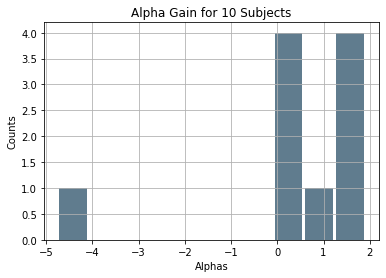

In [38]:
gain = pd.Series(precover['a_gain'])
print(gain)
gain.plot.hist(grid=True, bins=10, rwidth=0.9,
                   color='#607c8e')
plt.title('Alpha Gain for 10 Subjects')
plt.xlabel('Alphas')
plt.ylabel('Counts')
plt.grid(axis=precover['a_gain'], alpha=0.75)

In [39]:
print(precover['a_loss'])

0    2.089194
1    0.853833
2    0.381925
3   -1.937371
4    1.204512
5   -0.948530
6    0.657993
7    0.177283
8    2.127248
9    2.065813
Name: a_loss, dtype: float64


In [40]:
print(precover['beta'])

0    2.101523
1   -1.368390
2    3.711128
3    1.331697
4    1.259488
5    1.886924
6    2.390623
7    0.920245
8    0.932478
9    1.773850
Name: beta, dtype: float64
